# Simple example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyrotor

## Define settings

### Define quadratic cost function

In [2]:
# Cost function forcing the trajectory to be close to the horizontal axis

# Quadratic part
q = np.array([[0,0],
              [0,1]])
# Linear part
w = np.array([0,0])
# Constant part
c = 1

quadratic_model = [c, w, q]

### Define initial and final states

In [3]:
endpoints = {'x1': {'start': .111,
                    'end': .912,
                    'delta': 0.0001},
             'x2': {'start': .926,
                    'end': .211,
                    'delta': 0.0001}}

### Define independent variable (time)

In [4]:
independent_variable = {'start': .1,
                        'end': .9,
                        'frequency': .01}
# Compute number of evaluation points
delta_time = independent_variable['end'] - independent_variable['start']
delta_time /= independent_variable['frequency']
independent_variable['points_nb'] = int(delta_time) + 1

### Define constraints

In [5]:
# x1 > 0
def f1(data):
    x1 = data["x1"].values
    return x1

# x1 < 1
def f2(data):
    x1 = data["x1"].values
    return 1 - x1

# x2 > 0
def f3(data):
    x2 = data["x2"].values
    return x2

# x2 < 1
def f4(data):
    x2 = data["x2"].values
    return 1 - x2

# x2 > f(x1)
def f5(data):
    x1 = data["x1"].values
    x2 = data["x2"].values
    return x2 - 150/19 * (1-x1)**3 + 225/19 * (1-x1)**2 - 100/19 * (1-x1) + 79/190

constraints = [f1, f2, f3, f4, f5]

### Define functional basis

In [6]:
basis = 'legendre'
if basis == 'legendre':
    basis_features = {'x1': 4,
                      'x2': 6}
elif basis == 'bspline':
    basis_features = {'knots': [.33, .66],
                      'x1': 3,
                      'x2': 4}

### Import reference trajectories

In [7]:
reference_trajectories = pyrotor.datasets.load_toy_dataset("example_1")

/home/arthur/Documents/pyrotor/env/lib/python3.9/site-packages/pyrotor/toy_dataset/example_1/*.csv


## Optimization

### Create PyRotor class

In [8]:
mr_pyrotor = pyrotor.Pyrotor(quadratic_model, 
                             reference_trajectories, 
                             endpoints, 
                             constraints, 
                             basis, 
                             basis_features, 
                             independent_variable,
                             n_best_trajectory_to_use=5,
                             opti_factor=1,
                             quadratic_model=True,
                             use_quadratic_programming=True,
                             verbose=False)

### Execute PyRotor solver

In [9]:
mr_pyrotor.compute_optimal_trajectory()

### Compute savings

In [10]:
savings = pd.Series(mr_pyrotor.compute_gains(), name='Savings')
print(savings)

0    0.029582
1    0.030275
2    0.030388
3    0.031713
4    0.031808
Name: Savings, dtype: float64


In [11]:
relative_savings = pd.Series(mr_pyrotor.compute_relative_gains() * 100, name='Relative savings [%]')
print(relative_savings)

0    3.163290
1    3.235078
2    3.246697
3    3.383496
4    3.393335
Name: Relative savings [%], dtype: float64


## Plot

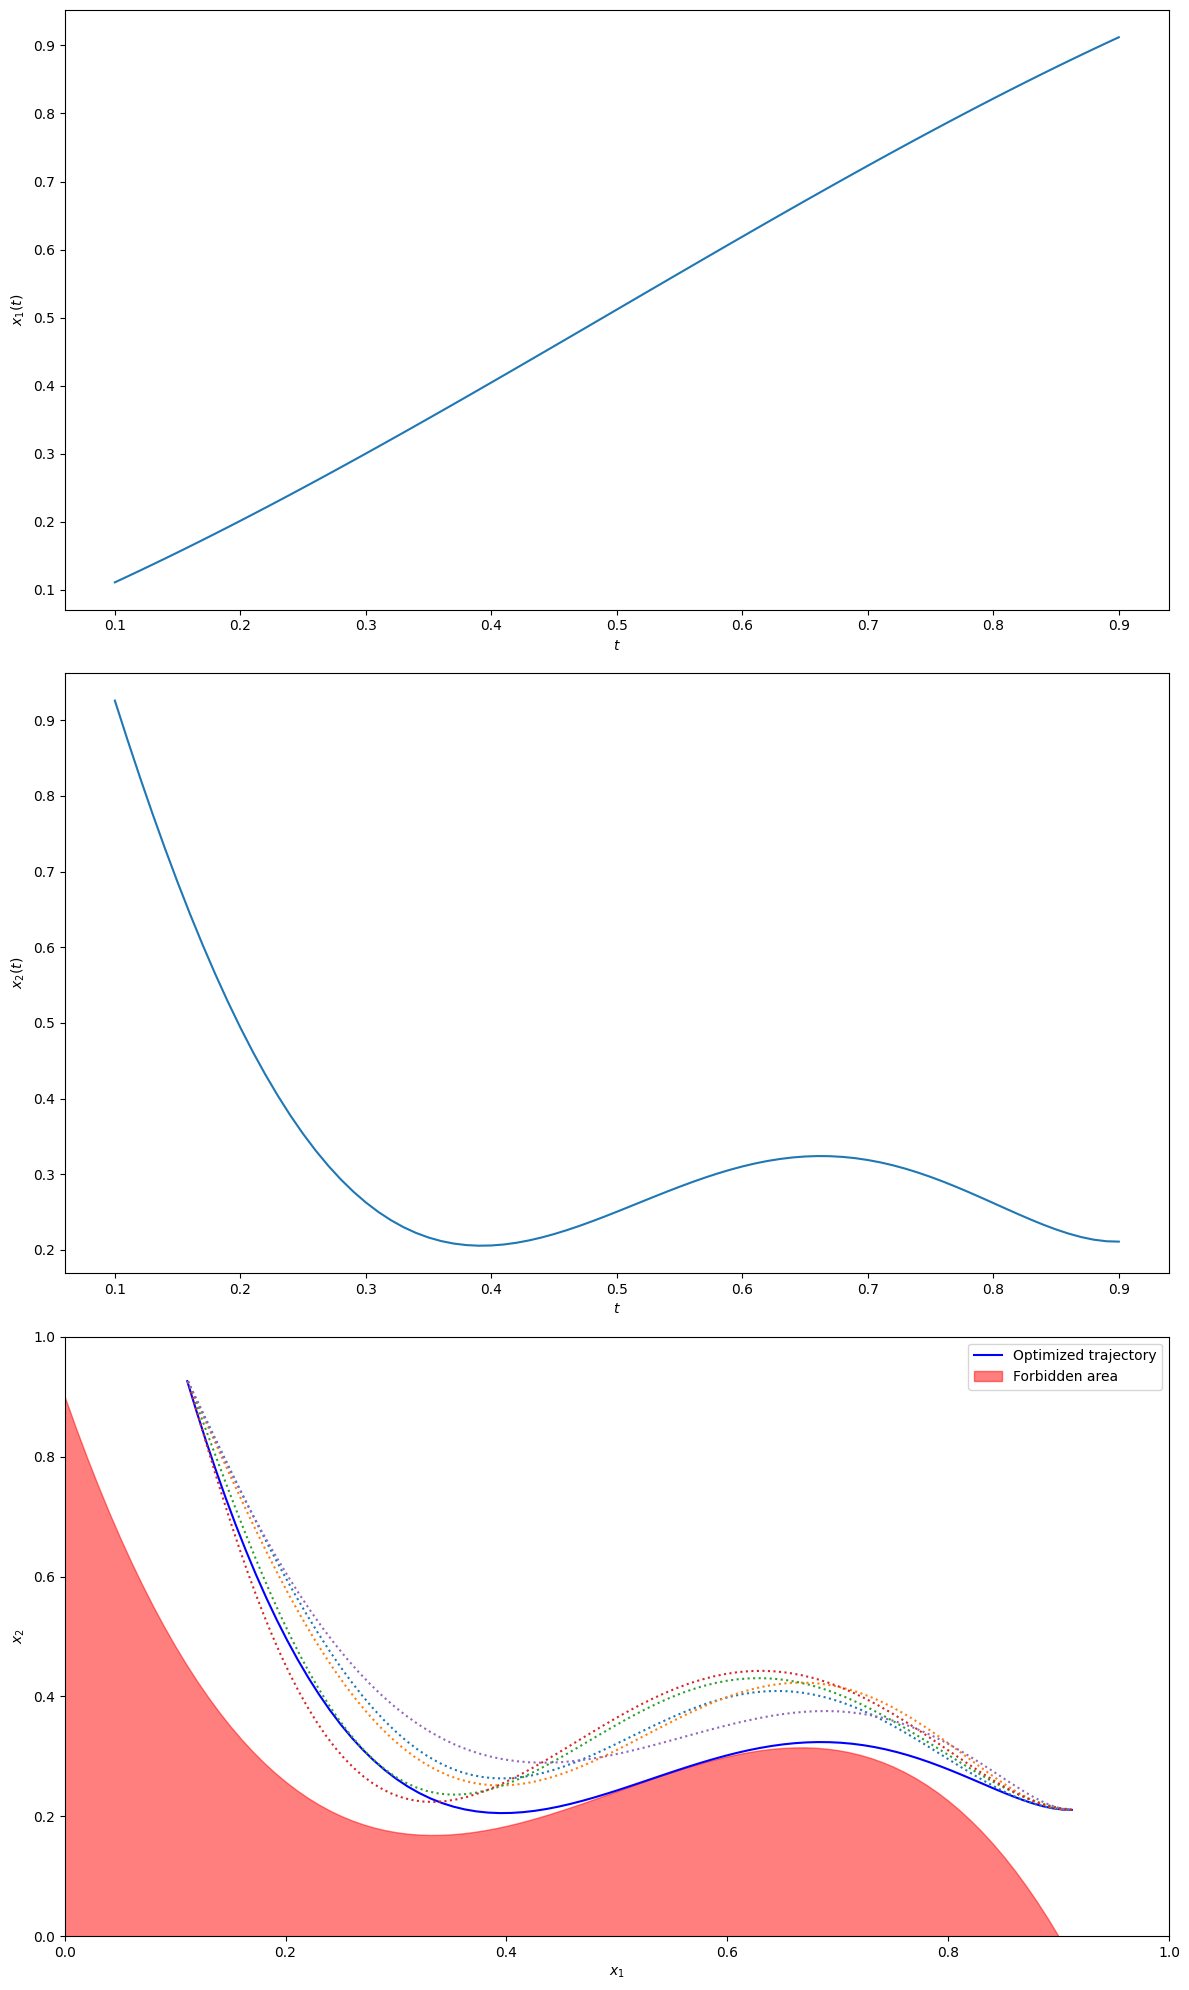

In [12]:
# Define time axis
X = np.linspace(independent_variable['start'],
                independent_variable['end'],
                independent_variable['points_nb'])

# Define nonlinear constraint to plot
X_ = np.linspace(0, 1, 101)
constraint_f5 = np.array([150/19 * (1-x)**3 - 225/19 * (1-x)**2 + 100/19 * (1-x) - 79/190 for x in X_])

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 20))
# Plot first variable with respect to time
ax1.plot(X, mr_pyrotor.trajectory['x1'])
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x_1(t)$')
# Plot second variable with respect to time
ax2.plot(X, mr_pyrotor.trajectory['x2'])
ax2.set_xlabel('$t$')
ax2.set_ylabel('$x_2(t)$')
# Plot in (x_1, x_2) space
ax3.plot(mr_pyrotor.trajectory['x1'], mr_pyrotor.trajectory['x2'], color='b', label='Optimized trajectory')
for trajectory in mr_pyrotor.reference_trajectories:
    ax3.plot(trajectory['x1'], trajectory['x2'], linestyle=":", label='_nolegend_')
ax3.fill_between(X_, 0, constraint_f5, color='r', alpha=.5, label='Forbidden area')
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$')
ax3.set_xlim(left=0, right=1)
ax3.set_ylim(bottom=0, top=1)
ax3.legend()
plt.tight_layout()